In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import optuna
import xgboost as xgb
import pickle
import os
import string 
import random
from datetime import date

from typing import List, TypeVar, Dict
import abc

from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from numpy import argmax


## Helper functions

In [2]:
_СORRELATION_MATRIX_PATH_ = 'corr_matrix.pcl'
_СHURN_PATH_ = 'churn_model.pcl'
_CHURN_PATH_REDUCED_ = 'churn_model_reduced.pcl' 
_MAX_FEATURES_ = 100

In [3]:
# https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
# https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
# https://www.statology.org/plot-roc-curve-python/
class Metrics:
    
    def roc_auc(y_true, predicted):
        return roc_auc_score(y_true, predicted)
    
    def auc(y_true, predicted):
        return average_precision_score(y_true, predicted)
    
    def plot_auc(y_true, predicted):
        fpr, tpr, _ = metrics.roc_curve(y_true, predicted)
        auc = metrics.roc_auc_score(y_true, predicted)
        plt.plot(fpr,tpr,label="AUC="+str(auc))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()
    
    def XY_plot(X, Y, legend:str, x_label:str, y_label:str):
        plt.plot(X,Y, label=legend)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.legend(loc=4)
        plt.show()
    
    def classification_report(y_true, predicted):
        return classification_report(y_true, predicted)
    
    def confusion_matrix(y_true, predicted):
        return confusion_matrix(y_true, predicted)

In [4]:
def get_random_string(length):
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [5]:
def get_float_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=int).columns.tolist()

def get_number_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(np.number).columns.tolist()

def get_obj_cols(df:DataFrame) -> List[str]:
    return list(df.select_dtypes(include=object).columns)
    
def get_empty_cols(df:DataFrame):
    return list(df.isnull().sum()[lambda x: x > 0].index)

In [6]:
def reduce_mem_usage(df, verbose=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test = test.drop(['ind'], axis=1)
    train = train.drop(['ind'], axis=1)
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    target = train['target']
    test_ids = test['Id']
    return combine, target, test_ids

def combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi):
    df_combine = pd.concat([train_df.assign(ind='train'), test_df.assign(ind='test')])
    df_combine_num = pd.concat([train_num.assign(ind='train'), test_num.assign(ind='test')])
    df_combine_dpi = pd.concat([train_dpi.assign(ind='train'), test_dpi.assign(ind='test')])
    return df_combine, df_combine_num, df_combine_dpi

## Data size reduction

In [8]:
def reduce_churn_data():

    if os.path.exists(_CHURN_PATH_REDUCED_) == False:
        if os.path.exists(_СHURN_PATH_) == True: 
    
            with open(_СHURN_PATH_, 'rb') as file:
                deserialized_object = pickle.load(file)

            deserialized_object = list(deserialized_object)
        
            # reduce size
            train_df= reduce_mem_usage(deserialized_object[1][1])
            train_num_reduced = reduce_mem_usage(deserialized_object[1][2])
            train_dpi_reduced = reduce_mem_usage(deserialized_object[1][3])

            test_df = reduce_mem_usage(deserialized_object[2][1])
            test_num_reduced = reduce_mem_usage(deserialized_object[2][2])
            test_dpi_reduced = reduce_mem_usage(deserialized_object[2][3])
            
            # dump data back
            deserialized_object = tuple([[train_df, train_num_reduced, train_dpi_reduced], [test_df, test_num_reduced, test_dpi_reduced]])
            pickle.dump(deserialized_object, open(_CHURN_PATH_REDUCED_, 'wb'))
    else:
        print(f'{_CHURN_PATH_REDUCED_} already exist')

In [9]:
def load_churn_data():

    with open(_СHURN_PATH_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[1][1]
    train_num = deserialized_object[1][2]
    train_dpi = deserialized_object[1][3]

    test_df = deserialized_object[2][1]
    test_num = deserialized_object[2][2]
    test_dpi = deserialized_object[2][3]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [10]:
def load_churn_reduced():

    with open(_CHURN_PATH_REDUCED_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[0][0]
    train_num = deserialized_object[0][1]
    train_dpi = deserialized_object[0][2]

    test_df = deserialized_object[1][0]
    test_num = deserialized_object[1][1]
    test_dpi = deserialized_object[1][2]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [11]:
def is_short_number(number:str) -> bool:
    if (number.isdigit() and len(number) <= 4):
        return True
    return False

def is_life(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['063', '093' ])):
        return True
    return False

def is_kyivstar(number:str) -> bool:
    if (len(number) == 12 and (number[2:5] in ['067', '097', '068', '098'])):
        return True
    return False

### Feature selectors

In [12]:
class FeatureHelper:
    
    def get_feature_correlation_df(corr_m, remove_duplicates=True, remove_self_correlations=True):
    
        corr_matrix_abs = corr_m.abs()
        corr_matrix_abs_us = corr_matrix_abs.unstack()
        sorted_correlated_features = corr_matrix_abs_us \
            .sort_values(kind="quicksort", ascending=False) \
            .reset_index()

        # Remove comparisons of the same feature
        if remove_self_correlations:
            sorted_correlated_features = sorted_correlated_features[
                (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
            ]

        # Remove duplicates
        if remove_duplicates:
            sorted_correlated_features = sorted_correlated_features.iloc[:-2:2]

        # Create meaningful names for the columns
        sorted_correlated_features.columns = ['f1', 'f2', 'corr']

        return sorted_correlated_features
    
    def get_correlation_matrix(df:DataFrame, method:str, save_path:str):
        if os.path.exists(save_path) == False:
            corr_matrix = df.corr(method = method, numeric_only = True)
            pickle.dump(corr_matrix, open(save_path, 'wb'))
        else:
            corr_matrix = pickle.load(open(save_path, 'rb'))

        return corr_matrix

    def remove_aggr_function(str_to_check:str) -> str:
        parts = str_to_check.split('_')
        
        if (len(parts) > 2):
            index_to_remove = len(parts) - 2
            
            # remove aggregation function
            if (parts[index_to_remove] in ['min', 'std', 'max', 'mea', 'td']):
                parts.remove(parts[index_to_remove])
                
            result = '_'.join(parts)
            return result
        else:
            return str_to_check    

        
    def get_heatmap_matrix(corr_matrix:DataFrame):
        heatmap_matrix = pd.DataFrame(corr_matrix['target'].abs())
        heatmap_matrix = heatmap_matrix.sort_values(by='target', ascending=False)
        heatmap_matrix = heatmap_matrix.drop(index=['target'])           
        return heatmap_matrix
    
    # index - column name
    # target - value
    def plot_heatmap(heatmap_matrix:DataFrame):
        plt.figure(figsize=(40, 120))
        heatmap = sns.heatmap(heatmap_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
        heatmap.set_title('Features Correlating with Churn Rate', fontdict={'fontsize':18}, pad=16);
        return heatmap_matrix
    
    def get_important_features(heatmap_matrix:DataFrame, use_groupping = False, num_of_features:int = -1):
        df_features = heatmap_matrix.reset_index()
        df_features = df_features.rename(columns = {'index':'feature'})
        
        # apply aggregation function for further groupping
        df_features['feature_group'] = df_features['feature'].apply(FeatureHelper.remove_aggr_function)
        df_features = df_features[['feature', 'feature_group', 'target']]
        sorted_features = df_features.sort_values(by=['feature_group', 'target'], ascending = [False, False])
        
        # take first item from the group
        if (use_groupping == True):
            important_features = sorted_features.groupby('feature_group').first()
        else:
            important_features = sorted_features

        # order by target
        important_features = important_features.sort_values(by='target', ascending=False)
           
        # take N first rows
        if (num_of_features != -1):
            important_features = important_features.head(num_of_features)
        
        # optimize for heatmap
        important_features = important_features.reset_index()
        important_features = important_features[['feature', 'target']]
        important_features.index = important_features['feature']
        important_features.index.name = None
        important_features = important_features[['target']]
        important_features = important_features[important_features['target'] > 0]
        
        return important_features
    
    def get_important_features_tuples(heatmap_matrix:DataFrame, num_of_features:int = -1):
        important_features = FeatureHelper.get_important_features(heatmap_matrix, num_of_features)
        
        if (num_of_features == -1):
            num_of_features = len(important_features)
        
        important_features_tuples = list(zip(important_features.index, 
                                             important_features.target, 
                                             list(range(0, num_of_features))))
        
        return important_features_tuples

In [13]:
class FeatureSelector(abc.ABC):

    @abc.abstractmethod
    def get_heatmap(self) -> pd.DataFrame:
        pass
    
    @abc.abstractmethod
    def plot_heatmap(self):
        pass

    @abc.abstractmethod
    # index - feature name, target
    def get_important_features(self) -> pd.DataFrame:
        pass
    
    @abc.abstractmethod
    # 1 - feature name, 2 - target, 3 - sorted number
    def get_important_features_tuples(self) -> List[tuple[str, float, int]]:
        pass

In [14]:
class CorrelationSelector(FeatureSelector):
    
    def __init__(self, data:pd.DataFrame, corr_method:str, num_of_features:int):
        self.data = data
        self.corr_method = corr_method
        self.file_prefix = corr_method
        self.num_of_features = num_of_features
        self.get_heatmap()
    
    def get_heatmap(self) -> pd.DataFrame:
        self.save_path = f'{self.file_prefix}_{_СORRELATION_MATRIX_PATH_}'
        self.corr_m = FeatureHelper.get_correlation_matrix(self.data, self.corr_method, self.save_path)
        self.heatmap_m = FeatureHelper.get_heatmap_matrix(self.corr_m)
        return self.heatmap_m 
    
    def get_important_features(self) -> pd.DataFrame:
        return FeatureHelper.get_important_features(self.heatmap_m, self.num_of_features)
    
    def plot_heatmap(self):
        FeatureHelper.plot_heatmap(self.get_important_features())
    
    def get_non_correlated_features(self, barrier_coef:float, do_log:bool) -> List[str]:
        
        important_tuples = FeatureHelper.get_important_features_tuples(self.heatmap_m, self.num_of_features)
        # f1, f2, corr
        features_corr = FeatureHelper.get_feature_correlation_df(self.corr_m)
        
        already_processed = set()
        all_features = [t[0] for t in important_tuples]

        for f in all_features:
            # get correlated features
            correlated = list(features_corr[(features_corr['f1']==f) & (features_corr['corr'] > barrier_coef)]['f2'])

            # if highly correlated features exist
            if (len(correlated)>0):

                for to_remove in correlated:
                    if (to_remove not in already_processed):
                        if (to_remove in all_features):
                            all_features.remove(to_remove)
                            if do_log: print(f'Removing: {to_remove} for {f}')            

        # remember initial feature
        already_processed.add(f)
        
        # return non-correlated features
        return all_features
    
    def get_important_noncorrelated_features_tuples(self, mutual_correlation:float, feature_importance:float):
        
        final = []
        important = self.get_important_features_tuples()
        non_correlated = self.get_non_correlated_features(mutual_correlation, False)
        
        for i in important:
            if (i[0] in non_correlated and i[1] > feature_importance):
                final.append(i)

        return final
                        
    def get_important_features_tuples(self) ->  List[tuple[str, float, int]]:
        return FeatureHelper.get_important_features_tuples(self.heatmap_m, self.num_of_features)
    
    def __str__(self):
        return type(self).__name__ + '_' + self.corr_method

In [15]:
# https://nitin9809.medium.com/lightgbm-binary-classification-multi-class-classification-regression-using-python-4f22032b36a2
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
class LGBMSelector(FeatureSelector):
    
    model_file = 'LGBMSelector_simple.pcl'
    heatmap_calculated = False
    
    def __init__(self, data:pd.DataFrame, num_of_features:int):
        self.data = data
        self.num_of_features = num_of_features
        self.train_model()
    
    def train_model(self):
        test, train = split_test_train(self.data)

        self.y_train = train['target'].round(0).astype(int)
        self.y_test = test['target'].round(0).astype(int)

        train = train.drop(['target'], axis=1)
        test = test.drop(['target'], axis=1)
        
        # regressor
        if os.path.exists(self.model_file) == True: 
            with open(self.model_file, 'rb') as file:
                self.regressor = pickle.load(file)
        else:         
            self.regressor = lg.LGBMClassifier()
            self.regressor.fit(train, self.y_train)
        
        # predict
        self.predicted = self.regressor.predict(test)
        
        #save model
        pickle.dump(self.regressor, open(self.model_file, 'wb'))
    
    def get_feature_importance_raw(self):
        return self.regressor.feature_importances_
    
    def get_heatmap(self) -> pd.DataFrame:
        df_feature_importance = pd.DataFrame(list(zip(list(self.get_feature_importance_raw()), list(self.data.columns))))
        df_feature_importance = df_feature_importance.set_axis(['target', 'feature'], axis=1)
        df_feature_importance = df_feature_importance.sort_values(by=['target'], ascending=False)
        df_feature_importance = df_feature_importance.set_index('feature')
        df_feature_importance.index.name = None
        self.heatmap_m = df_feature_importance
        self.heatmap_calculated = True
        return self.heatmap_m
    
    def plot_heatmap(self):
        FeatureHelper.plot_heatmap(self.get_important_features())

    def get_important_features(self) -> pd.DataFrame:
        if (self.heatmap_calculated == False):
            self.get_heatmap()
            
        return FeatureHelper.get_important_features(self.heatmap_m, self.num_of_features)
    
    def get_important_features_tuples(self) -> List[tuple[str, float, int]]:
        if (self.heatmap_calculated == False):
            self.get_heatmap()
            
        features_tuples = FeatureHelper.get_important_features_tuples(self.heatmap_m, self.num_of_features)
        return features_tuples
        
    def get_ROCAUC(self):
        return Metrics.roc_auc(self.y_test, self.predicted)

    def get_confusion_matrix(self):
        return Metrics.confusion_matrix(self.y_test, self.predicted)
    
    def get_classification_report(self):
        return Metrics.classification_report(self.y_test, self.predicted)
    
    def __str__(self):
        return type(self).__name__

In [16]:
# https://neptune.ai/blog/lightgbm-parameters-guide
class EnhancedLGBMSelector(LGBMSelector):
    
    def __init__(self, data, model_file_name:str = 'EnhancedLGBMSelector_model_800_features.pcl'):
        self.model_file = model_file_name
        super().__init__(data, -1)
    
    def get_feature_importance_raw(self):
        return self.regressor.feature_importance()
    
    def train_model(self):        
        
        test, train = split_test_train(self.data)

        self.y_train = train['target'].round(0).astype(int)
        self.y_test = test['target'].round(0).astype(int)

        x_train = train.drop(['target'], axis=1)
        x_test = test.drop(['target'], axis=1)

        # Specifying the parameter
        d_train = lg.Dataset(x_train, label=self.y_train)
        d_test = lg.Dataset(x_test, label=self.y_test, reference=d_train)

        # load model from disk
        if os.path.exists(self.model_file) == True: 
            with open(self.model_file, 'rb') as file:
                self.regressor = pickle.load(file)
        # Train model
        else:
            params={}
            params['boosting_type']='dart' 
            params['objective']='binary' 
            params['metric']='auc' 
            params['verbosity'] = 2

            #train the model 
            self.regressor=lg.train(params = params, 
                          train_set = d_train,
                          valid_sets = d_test, 
                          num_boost_round = 150, 
                          callbacks= [lg.early_stopping(stopping_rounds=20)])
        
        # make prediction
        self.predicted = self.regressor.predict(x_test)
        
        #save model
        print(f'Saving model to file {self.model_file}. Data shape: {self.data.shape}. ROCAUC: {Metrics.roc_auc(self.y_test, self.predicted)}')
        pickle.dump(self.regressor, open(self.model_file, 'wb'))


In [17]:
class IterativeLGBMSelector(FeatureSelector):
    
    results_file = 'IterativeLGBMSelector_results.pcl'
    model_file = 'IterativeLGBMSelector_model.pcl'
    
    def __init__(self, 
                 data:pd.DataFrame, 
                 selector:EnhancedLGBMSelector,
                 base_line_auc:float,
                 num_of_boosting_rounds:int,
                 do_log:bool):
        
        self.data = data
        self.trained_selector = selector
        self.base_line_auc = base_line_auc
        self.num_of_boosting_rounds = num_of_boosting_rounds
        self.do_log = do_log
        
        # check pre-saved results
        if os.path.exists(self.results_file) == True:
            
            with open(self.results_file, 'rb') as file:
                self.result = pickle.load(file)
            
            with open(self.model_file, 'rb') as file:
                self.regressor = pickle.load(file)
            
        else:
            self.result = self.train_model()
    
    def get_regressor(self):
        return self.regressor
    
    def get_training_results(self):
        return self.result
    
    def train_model(self):
        
        all_features = [f[0] for f in self.trained_selector.get_important_features_tuples()]
        do_log = True
        existing = ['target', 'ind']
        roc_auc = 0
        prev_roc_auc = 0
        increase_rate = 0
        result = []

        # for every column
        for c in list(all_features):
            if c != 'target':

                # add column
                existing.append(c)

                # new dataset
                df = df_combine[existing]

                # build model
                test, train = split_test_train(df)
                y_train = train['target'].round(0).astype(int)
                y_test = test['target'].round(0).astype(int)
                x_train = train.drop(['target'], axis=1)
                x_test = test.drop(['target'], axis=1)

                # create datasets
                d_train = lg.Dataset(x_train, label=y_train)
                d_test = lg.Dataset(x_test, label=y_test, reference=d_train)

                params={}
                params['boosting_type']='dart' 
                params['objective']='binary' 
                params['metric']='auc' 
                params['verbosity'] = 0

                #train the model 
                regressor=lg.train(params = params, 
                              train_set = d_train,
                              valid_sets = d_test, 
                              num_boost_round = self.num_of_boosting_rounds)

                # calculate metric
                predicted = regressor.predict(x_test)

                try:
                    roc_auc = Metrics.roc_auc(y_test, predicted)
                except ValueError:
                    roc_auc = -1

                # save result
                diff = roc_auc - prev_roc_auc
                item = (len(existing), existing, roc_auc, diff)
                result.append(item)
                if self.do_log == True: print(f'======== {len(existing)} -> AUC: {roc_auc} -> DIFF: {diff}' )

                if (roc_auc > self.base_line_auc):
                    if self.do_log == True: print(f'======== {roc_auc} increased base line threshold with {len(existing) -2} features {existing}')
                    break

                # handle negative impact
                if (diff < -0.01):
                    if self.do_log == True: print(f'======== Feature {c} gives negative impact of {diff}. Removing it.')
                    existing.remove(c)
                else:
                    prev_roc_auc = roc_auc
        
        # save result
        pickle.dump(result, open(self.results_file, 'wb'))
        pickle.dump(regressor, open(self.model_file, 'wb'))
        self.regressor = regressor
        f
        return result
    
    def get_heatmap(self) -> pd.DataFrame:
        pass
    
    def plot_heatmap(self):
        pass
    
    def get_important_features(self) -> pd.DataFrame:
        return self.result[-1][1][2:]
    
    def get_important_features_tuples(self) -> List[tuple[str, float, int]]:
        return self.result[-1][1][2:]

## Data Transformation

In [18]:
class TransformPipe:
    
    def __init__(self, funcs, **kwargs):
        self.funcs = funcs
        self.kwargs = kwargs
    
    def transform(self, df:DataFrame) -> DataFrame:
        for f in self.funcs:
            df = f(df, **self.kwargs)
            
        return df

In [19]:
# kwargs -> col_names_to_impute, verbose, impute_method
def impute_numeric_cols(df:DataFrame, **kwargs) -> DataFrame:
    
    impute_method = kwargs['impute_method']
    
    col_names = kwargs['col_names_to_impute']
    
    # all possible columns
    initial_cols = list(df.columns)
    
    for col_name in col_names:

        non_empty_numeric =  (set(get_number_cols(df)) - set(get_empty_cols(df))) | {col_name}        
        cols_names_to_drop = list((set(df.columns) - non_empty_numeric))
        
        if (kwargs['verbose']==True): print('Deleting: {0}. Imputing: {1}'.format(cols_names_to_drop, col_name))
        
        # save temp
        temp = df[cols_names_to_drop]

        # clear dataset 
        df = df.drop(columns=cols_names_to_drop)
        
        known = df.loc[ df[col_name].notnull() ]        
        unknown = df.loc[ df[col_name].isnull() ]
        
        # nothing to predict
        if (len(unknown) == 0): 
            if (kwargs['verbose']==True): print('Nothing to predict - continue')
            continue
        
        column_index = list(df.columns).index(col_name)

        all_indices = [i for i in range(unknown.shape[1])]
        diff = list(set(all_indices) - {column_index})

        y = known.values[:, column_index]
        X = known.values[:, diff]

        # select regressor
        if impute_method == 'randomforest':
            regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        if impute_method == 'knn':
            regressor = KNeighborsRegressor()
            
        regressor.fit(X, y)
        predicted = regressor.predict(unknown.values[:, diff])
        
        if (kwargs['verbose']==True): print('{0} was predicted. Len: {1}'.format(col_name, len(predicted)))
        
        # fill missings
        df.loc[ (df[col_name].isnull()), col_name ] = predicted
        
        # restore dataset
        df[cols_names_to_drop] = temp
    
    # reorder columns back
    df = df.reindex(columns = initial_cols)
    
    return df

In [20]:
def remove_skew(df:DataFrame, **kwargs) -> DataFrame:
    
    excluded_features = kwargs['excluded_features']
    
    skew_df = pd.DataFrame(get_number_cols(df), columns=['Feature'])
    skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature]))
    skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
    skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

    for column in skew_df.query("Skewed == True")['Feature'].values:
        if (column not in excluded_features):
            df[column] = np.log1p(df[column])
        else:
            print(f'Skipping column: {column}')
            
    return df

## Load Data

In [21]:
train_df, train_num, train_dpi, test_df, test_num, test_dpi = load_churn_reduced()
df_combine, df_combine_num, df_combine_dpi = combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi)

## Feature selection

In [22]:
# https://towardsdatascience.com/deep-dive-on-ml-techniques-for-feature-selection-in-python-part-2-c258f8a2ac43
# https://www.kaggle.com/code/gomes555/tps-jun2021-feature-selection-lightgbm-tuner

pearsonSelector = CorrelationSelector(df_combine, 'pearson', -1)
spearmanSelector = CorrelationSelector(df_combine, 'spearman', -1)
normal = LGBMSelector(df_combine, -1)
enhanced = EnhancedLGBMSelector(df_combine)

Saving model to file EnhancedLGBMSelector_model_800_features.pcl. Data shape: (300000, 818). ROCAUC: 0.8964107384015783


In [23]:
normal.get_ROCAUC(), enhanced.get_ROCAUC()

(0.6585018863563808, 0.8964107384015783)

In [24]:
pearson_non_corr = pearsonSelector.get_important_noncorrelated_features_tuples(0.9, 0.2)
spearman_non_corr = spearmanSelector.get_important_noncorrelated_features_tuples(0.9, 0.2)
len(pearson_non_corr), len(spearman_non_corr)

(36, 18)

In [25]:
features = [*[f[0] for f in pearson_non_corr], *['target', 'ind']]
df_temp = df_combine[features]
pearson_test_selector = EnhancedLGBMSelector(df_temp, get_random_string(10) + '.pcl')
pearson_test_selector.get_ROCAUC()

[LightGBM] [Info] Number of positive: 9586, number of negative: 140414
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.810292
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.229234
[LightGBM] [Debug] init for col-wise cost 0.003537 seconds, init for row-wise cost 0.025886 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7102
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063907 -> initscore=-2.684292
[LightGBM] [Info] Start training from score -2.684292
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31

C:\Users\Valentine\anaconda3\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Tra

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] 

0.8487911151722013

In [26]:
features = [*[f[0] for f in spearman_non_corr], *['target', 'ind']]
df_temp = df_combine[features]
spearman_test_selector = EnhancedLGBMSelector(df_temp, get_random_string(10) + '.pcl')
spearman_test_selector.get_ROCAUC()

[LightGBM] [Info] Number of positive: 9586, number of negative: 140414
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.865644
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.299684
[LightGBM] [Debug] init for col-wise cost 0.006220 seconds, init for row-wise cost 0.023834 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2812
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063907 -> initscore=-2.684292
[LightGBM] [Info] Start training from score -2.684292
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8


C:\Users\Valentine\anaconda3\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Tr

0.8448879034572125

In [30]:
iterative = IterativeLGBMSelector(df_combine, enhanced, 0.89, 150, True)
iterativeFeatures = iterative.get_important_features()
results = iterative.get_training_results()

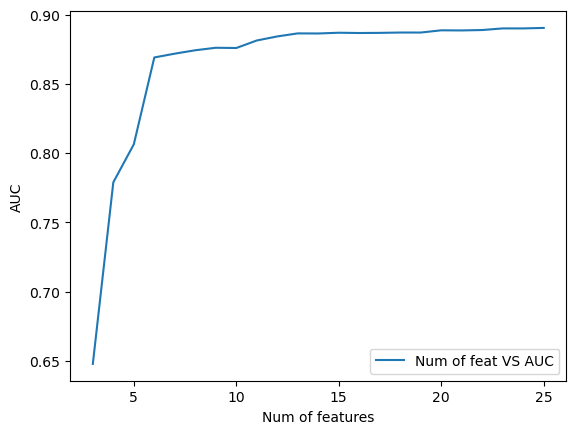

In [28]:
X = [r[0] for r in results]
Y = [r[2] for r in results]
Metrics.XY_plot(X, Y, 'Num of feat VS AUC', 'Num of features', 'AUC')

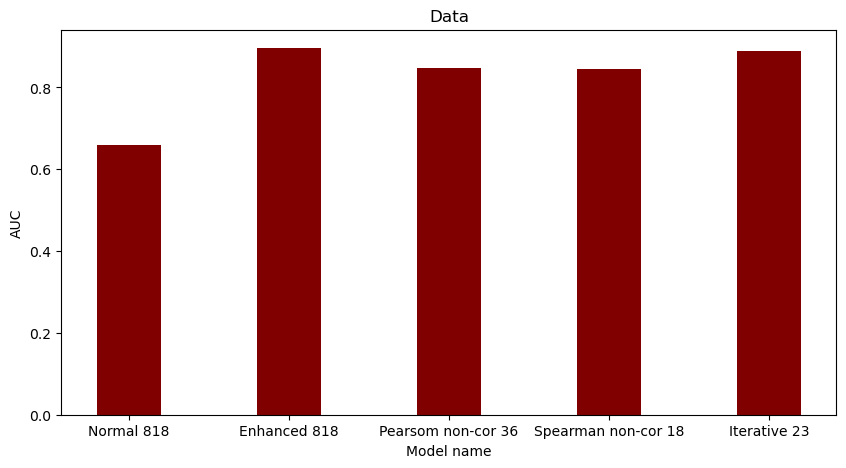

In [39]:
X = ['Normal' + ' ' + str(df_combine.shape[1]),
     'Enhanced' + ' ' + str(df_combine.shape[1]), 
     'Pearsom non-cor' + ' ' + str(len(pearson_non_corr)), 
     'Spearman non-cor'+ ' ' + str(len(spearman_non_corr)),
     'Iterative' + ' ' + str(len(iterativeFeatures))]

Y = [normal.get_ROCAUC(),
     enhanced.get_ROCAUC(),
     pearson_test_selector.get_ROCAUC(),
     spearman_test_selector.get_ROCAUC(),
     results[-1][2]]
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(X, Y, color ='maroon', width = 0.4)
 
plt.xlabel("Model name")
plt.ylabel("AUC")
plt.title("Data")
plt.show()

## Filling Missing Data

In [ ]:
finalFeatures = [*[f for f in iterativeFeatures], *['target', 'ind']]
df_final = df_combine[finalFeatures]

In [ ]:
# get_empty_cols(df_final)

In [ ]:
imputed_path = 'final_dataset_knn.pcl'

if os.path.exists(imputed_path) == True:
    df_final = pickle.load(open(imputed_path, 'rb'))
else:
    # kwargs -> col_names_to_impute, verbose, impute_method
    df_final = impute_numeric_cols(df_final, col_names_to_impute = get_empty_cols(df_final), verbose = True, impute_method = 'knn')
    pickle.dump(df_final, open(imputed_path, 'wb'))

In [ ]:
imputed_path = 'final_dataset_randomforest.pcl'

if os.path.exists(imputed_path) == True:
    df_final = pickle.load(open(imputed_path, 'rb'))
else:
    # kwargs -> col_names_to_impute, verbose, impute_method
    df_final = impute_numeric_cols(df_final, col_names_to_impute = get_empty_cols(df_final), verbose = True, impute_method = 'randomforest')
    pickle.dump(df_final, open(imputed_path, 'wb'))

In [ ]:
df_final = remove_skew(df_final, excluded_features = ['target'])

In [ ]:
enhanced_final = EnhancedLGBMSelector(df_final, get_random_string(10) + '.pcl')

### Check if dataset is balanced

In [ ]:
churned = len(df_combine[df_combine['target'] == 1])
not_churned = len(df_combine[df_combine['target'] == 0])

In [ ]:
y = [churned, not_churned]
x = ['Churned', 'Not churned']
plt.bar(x,y)
plt.show()

## Feature engineering
#### Check inbound calls from non-vodaphone number
#### Check outbound calls to non-vodaphone number
#### SMS from non-vodaphone number
#### SMS to non-vodaphone number

## Correlation matrix

## Explore numbers abonent had communication with + frequency

In [ ]:
churned = df_combine[df_combine['target'] == 1]
churned_with_nums = pd.merge(churned, df_combine_num, on='abon_id', how='left')
churned_numbers = list(churned_with_nums['bnum'].unique())

non_churned = df_combine[df_combine['target'] == 0]
non_churned_with_nums = pd.merge(non_churned, df_combine_num, on='abon_id', how='left')
non_churned_numbers = list(non_churned_with_nums['bnum'].unique())

number_abon_had_communicated = (set(churned_numbers) - set(non_churned_numbers))
df_number_abon_had_communicated = pd.DataFrame(number_abon_had_communicated, columns= ['bnum'])

In [ ]:
churned_with_nums[churned_with_nums['bnum'].isin(list(number_abon_had_communicated))]

In [ ]:
churned_with_nums

## Telephone Feature

## Groupping

In [ ]:
gr = train_num.groupby(['abon_id'])
gr.groups

In [ ]:
# cor_matrix = train_df.corr()

##### 